# DBSCAN: Density-Based Spatial Clustering - A Discovery Journey

## Overview
DBSCAN (Density-Based Spatial Clustering of Applications with Noise) finds clusters of arbitrary shape and identifies outliers. Unlike K-means, it doesn't require specifying the number of clusters beforehand!

### Learning Objectives:
- Understand density-based clustering concepts
- Implement DBSCAN from scratch
- Master parameter selection (eps and min_samples)
- Compare DBSCAN with K-means
- Apply DBSCAN to real-world problems

## Part 0: All Function Definitions
All functions used throughout this notebook are defined here.

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs, make_moons, make_circles, make_swiss_roll
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd
from collections import deque
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

In [38]:
# ============================================
# DATA GENERATION FUNCTIONS
# ============================================

def generate_dbscan_data(data_type='mixed', n_samples=500, noise_ratio=0.05, random_state=42):
    """Generate various types of data suitable for DBSCAN experiments."""
    np.random.seed(random_state)
    
    if data_type == 'mixed':
        # Create clusters with different densities
        X1, _ = make_blobs(n_samples=n_samples//3, centers=2, cluster_std=0.5, random_state=random_state)
        X2, _ = make_blobs(n_samples=n_samples//3, centers=1, cluster_std=2.0, random_state=random_state)
        X2[:, 0] += 10
        X3, _ = make_moons(n_samples=n_samples//3, noise=0.05, random_state=random_state)
        X3 = X3 * 3 + [5, 5]
        X = np.vstack([X1, X2, X3])
        
    elif data_type == 'moons':
        X, _ = make_moons(n_samples=n_samples, noise=0.05, random_state=random_state)
        X = X * 3
        
    elif data_type == 'circles':
        X, _ = make_circles(n_samples=n_samples, factor=0.5, noise=0.05, random_state=random_state)
        X = X * 3
        
    elif data_type == 'anisotropic':
        X, _ = make_blobs(n_samples=n_samples, centers=3, random_state=random_state)
        transformation = [[0.6, -0.6], [-0.4, 0.8]]
        X = np.dot(X, transformation)
        
    elif data_type == 'varied_density':
        # Create clusters with very different densities
        X1, _ = make_blobs(n_samples=n_samples//2, centers=1, cluster_std=0.2, random_state=random_state)
        X2, _ = make_blobs(n_samples=n_samples//4, centers=1, cluster_std=1.5, random_state=random_state)
        X2[:, 0] += 5
        X3, _ = make_blobs(n_samples=n_samples//4, centers=1, cluster_std=0.3, random_state=random_state)
        X3 += [2, -3]
        X = np.vstack([X1, X2, X3])
        
    elif data_type == 'swiss_roll':
        from sklearn.datasets import make_swiss_roll
        X, _ = make_swiss_roll(n_samples=n_samples, random_state=random_state)
        X = X[:, [0, 2]]  # Use only 2D
        X = StandardScaler().fit_transform(X)
        
    else:
        # Default: blobs with noise
        X, _ = make_blobs(n_samples=n_samples, centers=3, cluster_std=0.5, random_state=random_state)
    
    # Add noise points
    if noise_ratio > 0:
        n_noise = int(n_samples * noise_ratio)
        noise_points = np.random.uniform(X.min(axis=0) - 1, X.max(axis=0) + 1, (n_noise, 2))
        X = np.vstack([X, noise_points])
    
    return X

def create_density_grid(X, resolution=100):
    """Create a density grid for visualization."""
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution),
                        np.linspace(y_min, y_max, resolution))
    
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    
    # Calculate density at each grid point
    from scipy.stats import gaussian_kde
    kde = gaussian_kde(X.T)
    density = kde(grid_points.T).reshape(xx.shape)
    
    return xx, yy, density

In [39]:
# ============================================
# DBSCAN IMPLEMENTATION FUNCTIONS
# ============================================

def euclidean_distance(p1, p2):
    """Calculate Euclidean distance between two points."""
    return np.sqrt(np.sum((p1 - p2) ** 2))

def find_neighbors(X, point_idx, eps):
    """Find all points within eps distance of point_idx."""
    neighbors = []
    for idx in range(len(X)):
        if euclidean_distance(X[point_idx], X[idx]) <= eps:
            neighbors.append(idx)
    return neighbors

def find_neighbors_efficient(X, point_idx, eps, kdtree=None):
    """Efficient neighbor finding using KDTree."""
    if kdtree is None:
        from scipy.spatial import KDTree
        kdtree = KDTree(X)
    
    neighbors = kdtree.query_ball_point(X[point_idx], eps)
    return neighbors

def dbscan_from_scratch(X, eps, min_samples, visualize_steps=False):
    """DBSCAN implementation from scratch with optional visualization."""
    n_points = len(X)
    labels = np.full(n_points, -1)  # -1 means unclassified
    cluster_id = 0
    
    # For efficient neighbor search
    from scipy.spatial import KDTree
    kdtree = KDTree(X)
    
    # History for visualization
    history = {'labels': [], 'core_points': [], 'border_points': [], 'noise_points': []}
    
    # Classify points as core, border, or noise
    point_types = np.zeros(n_points)  # 0: unprocessed, 1: core, 2: border, -1: noise
    
    for point_idx in range(n_points):
        if labels[point_idx] != -1:  # Already processed
            continue
            
        neighbors = find_neighbors_efficient(X, point_idx, eps, kdtree)
        
        if len(neighbors) < min_samples:
            labels[point_idx] = -2  # Mark as noise (will be -1 in final output)
            point_types[point_idx] = -1
            continue
        
        # Core point found - expand cluster
        point_types[point_idx] = 1
        labels[point_idx] = cluster_id
        
        # Use queue for cluster expansion
        seed_set = deque(neighbors)
        processed = set([point_idx])
        
        while seed_set:
            current_point = seed_set.popleft()
            
            if current_point in processed:
                continue
            processed.add(current_point)
            
            if labels[current_point] == -2:  # Was noise
                labels[current_point] = cluster_id
                point_types[current_point] = 2  # Border point
                
            if labels[current_point] != -1:  # Already in a cluster
                continue
                
            labels[current_point] = cluster_id
            
            current_neighbors = find_neighbors_efficient(X, current_point, eps, kdtree)
            
            if len(current_neighbors) >= min_samples:
                point_types[current_point] = 1  # Core point
                for neighbor in current_neighbors:
                    if neighbor not in processed:
                        seed_set.append(neighbor)
            else:
                point_types[current_point] = 2  # Border point
        
        if visualize_steps:
            history['labels'].append(labels.copy())
            history['core_points'].append(np.where(point_types == 1)[0])
            history['border_points'].append(np.where(point_types == 2)[0])
            history['noise_points'].append(np.where(point_types == -1)[0])
        
        cluster_id += 1
    
    # Convert noise labels from -2 to -1
    labels[labels == -2] = -1
    
    return labels, history, point_types

def expand_cluster(X, labels, point_idx, cluster_id, eps, min_samples, kdtree):
    """Expand a cluster from a core point."""
    seeds = find_neighbors_efficient(X, point_idx, eps, kdtree)
    
    if len(seeds) < min_samples:
        labels[point_idx] = -1  # Noise
        return False
    
    labels[seeds] = cluster_id
    seeds = deque(seeds)
    seeds.remove(point_idx)
    
    while seeds:
        current_point = seeds.popleft()
        neighbors = find_neighbors_efficient(X, current_point, eps, kdtree)
        
        if len(neighbors) >= min_samples:
            for neighbor in neighbors:
                if labels[neighbor] == -1 or labels[neighbor] == 0:
                    if labels[neighbor] == 0:
                        seeds.append(neighbor)
                    labels[neighbor] = cluster_id
    
    return True

In [40]:
# ============================================
# VISUALIZATION FUNCTIONS
# ============================================

def plot_dbscan_clusters(X, labels, title='DBSCAN Clustering', ax=None, show_noise=True):
    """Plot DBSCAN clustering results."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    unique_labels = set(labels)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
    
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise
            if show_noise:
                col = 'black'
                marker = 'x'
                alpha = 0.3
                size = 30
            else:
                continue
        else:
            marker = 'o'
            alpha = 0.6
            size = 50
        
        class_member_mask = (labels == k)
        xy = X[class_member_mask]
        
        label = 'Noise' if k == -1 else f'Cluster {k}'
        ax.scatter(xy[:, 0], xy[:, 1], c=[col], marker=marker, 
                  s=size, alpha=alpha, label=label, edgecolors='black', linewidth=0.5)
    
    ax.set_title(title)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.grid(True, alpha=0.3)
    
    # Statistics
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    
    stats_text = f'Clusters: {n_clusters}, Noise points: {n_noise}'
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
           verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    return ax

def plot_density_map(X, eps=None, resolution=100, ax=None):
    """Plot density map of the data."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    xx, yy, density = create_density_grid(X, resolution)
    
    # Plot density contours
    contour = ax.contourf(xx, yy, density, levels=20, cmap='YlOrRd', alpha=0.6)
    ax.scatter(X[:, 0], X[:, 1], c='black', s=20, alpha=0.5)
    
    if eps is not None:
        # Draw eps neighborhoods for a few random points
        sample_points = np.random.choice(len(X), min(5, len(X)), replace=False)
        for idx in sample_points:
            circle = plt.Circle((X[idx, 0], X[idx, 1]), eps, 
                              fill=False, edgecolor='blue', linewidth=2, linestyle='--')
            ax.add_patch(circle)
    
    ax.set_title('Data Density Map')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    plt.colorbar(contour, ax=ax, label='Density')
    
    return ax

def plot_point_types(X, point_types, eps, ax=None):
    """Visualize core points, border points, and noise."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    core_mask = point_types == 1
    border_mask = point_types == 2
    noise_mask = point_types == -1
    
    # Plot different point types
    if np.any(core_mask):
        ax.scatter(X[core_mask, 0], X[core_mask, 1], c='red', s=100, 
                  marker='o', label='Core points', alpha=0.8, edgecolors='black')
    
    if np.any(border_mask):
        ax.scatter(X[border_mask, 0], X[border_mask, 1], c='yellow', s=60, 
                  marker='s', label='Border points', alpha=0.8, edgecolors='black')
    
    if np.any(noise_mask):
        ax.scatter(X[noise_mask, 0], X[noise_mask, 1], c='gray', s=30, 
                  marker='x', label='Noise points', alpha=0.5)
    
    # Draw eps radius for some core points
    core_indices = np.where(core_mask)[0]
    if len(core_indices) > 0:
        sample_cores = np.random.choice(core_indices, min(3, len(core_indices)), replace=False)
        for idx in sample_cores:
            circle = plt.Circle((X[idx, 0], X[idx, 1]), eps, 
                              fill=False, edgecolor='red', linewidth=1, linestyle='--', alpha=0.5)
            ax.add_patch(circle)
    
    ax.set_title(f'Point Classification (eps={eps:.2f})')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal', adjustable='box')
    
    return ax

def animate_dbscan_expansion(X, history, interval=500):
    """Animate DBSCAN cluster expansion."""
    def update(step):
        clear_output(wait=True)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        
        if step < len(history['labels']):
            # Current clustering state
            labels = history['labels'][step]
            plot_dbscan_clusters(X, labels, f'Step {step + 1}', ax1)
            
            # Point types
            point_types = np.zeros(len(X))
            if step < len(history['core_points']):
                point_types[history['core_points'][step]] = 1
                point_types[history['border_points'][step]] = 2
                point_types[history['noise_points'][step]] = -1
            
            core_mask = point_types == 1
            border_mask = point_types == 2
            noise_mask = point_types == -1
            
            if np.any(core_mask):
                ax2.scatter(X[core_mask, 0], X[core_mask, 1], c='red', s=100, 
                          marker='o', label='Core', alpha=0.8)
            if np.any(border_mask):
                ax2.scatter(X[border_mask, 0], X[border_mask, 1], c='yellow', s=60, 
                          marker='s', label='Border', alpha=0.8)
            if np.any(noise_mask):
                ax2.scatter(X[noise_mask, 0], X[noise_mask, 1], c='gray', s=30, 
                          marker='x', label='Noise', alpha=0.5)
            
            ax2.set_title('Point Types')
            ax2.legend()
            ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    step_slider = widgets.IntSlider(
        value=0,
        min=0,
        max=max(0, len(history['labels'])-1),
        step=1,
        description='Step:',
        continuous_update=False
    )
    
    play_button = widgets.Play(
        value=0,
        min=0,
        max=max(0, len(history['labels'])-1),
        step=1,
        interval=interval,
        description="Play"
    )
    
    widgets.jslink((play_button, 'value'), (step_slider, 'value'))
    ui = widgets.HBox([play_button, step_slider])
    out = widgets.interactive_output(update, {'step': step_slider})
    
    display(ui, out)

In [41]:
# ============================================
# PARAMETER SELECTION FUNCTIONS
# ============================================

def plot_k_distance(X, k=4, ax=None):
    """Plot k-distance graph for eps parameter selection."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    
    # Calculate k-nearest neighbors
    nbrs = NearestNeighbors(n_neighbors=k+1)  # +1 because point itself is included
    nbrs.fit(X)
    distances, indices = nbrs.kneighbors(X)
    
    # Sort k-th nearest neighbor distances
    k_distances = distances[:, k]  # k-th neighbor distance for each point
    k_distances = np.sort(k_distances, axis=0)
    
    # Plot
    ax.plot(range(len(k_distances)), k_distances, 'b-', linewidth=2)
    ax.set_xlabel('Points sorted by k-distance')
    ax.set_ylabel(f'{k}-distance')
    ax.set_title(f'{k}-Distance Graph (look for the elbow)')
    ax.grid(True, alpha=0.3)
    
    # Add annotation
    ax.text(0.7, 0.9, 'Choose eps at the elbow\n(sharp increase)',
           transform=ax.transAxes, bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))
    
    return ax, k_distances

def estimate_eps(X, k=4, percentile=95):
    """Automatically estimate eps using k-distance graph."""
    nbrs = NearestNeighbors(n_neighbors=k+1)
    nbrs.fit(X)
    distances, _ = nbrs.kneighbors(X)
    
    k_distances = distances[:, k]
    eps = np.percentile(k_distances, percentile)
    
    return eps

def parameter_space_analysis(X, eps_range, min_samples_range):
    """Analyze DBSCAN performance across parameter space."""
    results = []
    
    for eps in eps_range:
        for min_samples in min_samples_range:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(X)
            
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = list(labels).count(-1)
            
            # Calculate metrics only if we have clusters
            if n_clusters > 1:
                # Filter out noise for silhouette score
                mask = labels != -1
                if np.sum(mask) > 1 and len(np.unique(labels[mask])) > 1:
                    silhouette = silhouette_score(X[mask], labels[mask])
                else:
                    silhouette = -1
            else:
                silhouette = -1
            
            results.append({
                'eps': eps,
                'min_samples': min_samples,
                'n_clusters': n_clusters,
                'n_noise': n_noise,
                'silhouette': silhouette
            })
    
    return pd.DataFrame(results)

def plot_parameter_heatmap(results_df, metric='n_clusters'):
    """Plot heatmap of DBSCAN results across parameter space."""
    pivot_table = results_df.pivot(index='min_samples', columns='eps', values=metric)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.heatmap(pivot_table, annot=True, fmt='.2f' if metric == 'silhouette' else '.0f',
                cmap='YlOrRd', ax=ax, cbar_kws={'label': metric})
    ax.set_title(f'DBSCAN Parameter Space: {metric}')
    ax.set_xlabel('eps')
    ax.set_ylabel('min_samples')
    
    return fig

In [42]:
# ============================================
# INTERACTIVE WIDGET FUNCTIONS
# ============================================

def interactive_dbscan_parameters():
    """Interactive widget to explore DBSCAN parameters."""
    def update(data_type, eps, min_samples, show_density):
        X = generate_dbscan_data(data_type, n_samples=300, noise_ratio=0.05)
        
        # Run DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X)
        
        # Plotting
        fig, axes = plt.subplots(1, 3 if show_density else 2, figsize=(18 if show_density else 12, 5))
        
        # Original data
        axes[0].scatter(X[:, 0], X[:, 1], c='gray', s=50, alpha=0.6)
        axes[0].set_title('Original Data')
        axes[0].grid(True, alpha=0.3)
        
        # DBSCAN result
        plot_dbscan_clusters(X, labels, f'DBSCAN (eps={eps:.2f}, min_samples={min_samples})', axes[1])
        
        # Density map
        if show_density:
            plot_density_map(X, eps=eps, ax=axes[2])
        
        plt.tight_layout()
        plt.show()
        
        # Print statistics
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        print(f"\nResults:")
        print(f"Clusters found: {n_clusters}")
        print(f"Noise points: {n_noise} ({100*n_noise/len(X):.1f}%)")
        
        if n_clusters > 1:
            mask = labels != -1
            if np.sum(mask) > 1:
                score = silhouette_score(X[mask], labels[mask])
                print(f"Silhouette score: {score:.3f}")
    
    widgets.interact(update,
                    data_type=['mixed', 'moons', 'circles', 'varied_density', 'anisotropic'],
                    eps=widgets.FloatSlider(min=0.1, max=3.0, value=0.5, step=0.1, description='eps:'),
                    min_samples=widgets.IntSlider(min=2, max=20, value=5, description='min_samples:'),
                    show_density=widgets.Checkbox(value=False, description='Show density map'))

def interactive_point_inspection():
    """Interactive visualization to understand point types."""
    X = generate_dbscan_data('mixed', n_samples=150, noise_ratio=0.1)
    
    def update(eps, min_samples, point_idx):
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        # Calculate neighbors for selected point
        from scipy.spatial import KDTree
        kdtree = KDTree(X)
        neighbors = kdtree.query_ball_point(X[point_idx], eps)
        
        # Left plot: Show selected point and its neighborhood
        axes[0].scatter(X[:, 0], X[:, 1], c='gray', s=30, alpha=0.3)
        axes[0].scatter(X[neighbors, 0], X[neighbors, 1], c='blue', s=50, alpha=0.6)
        axes[0].scatter(X[point_idx, 0], X[point_idx, 1], c='red', s=200, marker='*')
        
        circle = plt.Circle((X[point_idx, 0], X[point_idx, 1]), eps,
                           fill=False, edgecolor='red', linewidth=2)
        axes[0].add_patch(circle)
        
        point_type = 'Core' if len(neighbors) >= min_samples else 'Non-core'
        axes[0].set_title(f'Point {point_idx}: {point_type} (neighbors={len(neighbors)})')
        axes[0].set_aspect('equal')
        axes[0].grid(True, alpha=0.3)
        
        # Right plot: Full DBSCAN result
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X)
        plot_dbscan_clusters(X, labels, 'DBSCAN Result', axes[1])
        
        # Highlight selected point
        axes[1].scatter(X[point_idx, 0], X[point_idx, 1], c='red', s=200, 
                       marker='*', edgecolors='black', linewidth=2)
        
        plt.tight_layout()
        plt.show()
        
        cluster_label = labels[point_idx]
        if cluster_label == -1:
            print(f"Point {point_idx} is classified as NOISE")
        else:
            print(f"Point {point_idx} belongs to Cluster {cluster_label}")
    
    widgets.interact(update,
                    eps=widgets.FloatSlider(min=0.1, max=3.0, value=0.5, step=0.1),
                    min_samples=widgets.IntSlider(min=2, max=10, value=4),
                    point_idx=widgets.IntSlider(min=0, max=len(X)-1, value=0, description='Point:'))

In [43]:
# ============================================
# COMPARISON AND EVALUATION FUNCTIONS
# ============================================

def compare_dbscan_kmeans(X, eps, min_samples, k):
    """Compare DBSCAN and K-means on the same dataset."""
    # Run DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan_labels = dbscan.fit_predict(X)
    
    # Run K-means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(X)
    
    # Create comparison plot
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Original data
    axes[0].scatter(X[:, 0], X[:, 1], c='gray', s=50, alpha=0.6)
    axes[0].set_title('Original Data')
    axes[0].grid(True, alpha=0.3)
    
    # DBSCAN
    plot_dbscan_clusters(X, dbscan_labels, 
                        f'DBSCAN (eps={eps}, min_samples={min_samples})', axes[1])
    
    # K-means
    scatter = axes[2].scatter(X[:, 0], X[:, 1], c=kmeans_labels, s=50, alpha=0.6, cmap='viridis')
    axes[2].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
                   c='red', s=200, marker='*', edgecolors='black', linewidth=2)
    axes[2].set_title(f'K-means (k={k})')
    axes[2].grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=axes[2])
    
    plt.tight_layout()
    
    # Calculate metrics
    dbscan_n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    dbscan_n_noise = list(dbscan_labels).count(-1)
    
    print("\nComparison Results:")
    print("="*50)
    print(f"DBSCAN: {dbscan_n_clusters} clusters, {dbscan_n_noise} noise points")
    print(f"K-means: {k} clusters (predefined), 0 noise points")
    
    # Silhouette scores
    if dbscan_n_clusters > 1:
        mask = dbscan_labels != -1
        if np.sum(mask) > 1:
            dbscan_silhouette = silhouette_score(X[mask], dbscan_labels[mask])
            print(f"\nDBSCAN Silhouette: {dbscan_silhouette:.3f}")
    
    kmeans_silhouette = silhouette_score(X, kmeans_labels)
    print(f"K-means Silhouette: {kmeans_silhouette:.3f}")
    
    return fig

def evaluate_clustering_stability(X, eps_range, min_samples, n_bootstrap=10):
    """Evaluate DBSCAN stability through bootstrap sampling."""
    stability_scores = []
    
    for eps in eps_range:
        labels_list = []
        
        for _ in range(n_bootstrap):
            # Bootstrap sample
            indices = np.random.choice(len(X), len(X), replace=True)
            X_bootstrap = X[indices]
            
            # Run DBSCAN
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(X_bootstrap)
            labels_list.append(labels)
        
        # Calculate stability (average pairwise ARI)
        ari_scores = []
        for i in range(n_bootstrap):
            for j in range(i+1, n_bootstrap):
                # Only compare non-noise points
                mask = (labels_list[i] != -1) & (labels_list[j] != -1)
                if np.sum(mask) > 0:
                    ari = adjusted_rand_score(labels_list[i][mask], labels_list[j][mask])
                    ari_scores.append(ari)
        
        stability = np.mean(ari_scores) if ari_scores else 0
        stability_scores.append(stability)
    
    return stability_scores

In [44]:
# ============================================
# APPLICATION FUNCTIONS
# ============================================

def anomaly_detection_demo():
    """Demonstrate DBSCAN for anomaly detection."""
    np.random.seed(42)
    
    # Generate normal data
    normal_data = np.random.multivariate_normal([0, 0], [[1, 0.5], [0.5, 1]], 300)
    
    # Add anomalies
    anomalies = np.random.uniform(-6, 6, (20, 2))
    
    # Combine data
    X = np.vstack([normal_data, anomalies])
    true_labels = np.array([0]*300 + [1]*20)  # 0: normal, 1: anomaly
    
    # Run DBSCAN
    eps = 0.5
    min_samples = 10
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X)
    
    # Identify anomalies (noise points)
    detected_anomalies = labels == -1
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # True anomalies
    axes[0].scatter(X[true_labels==0, 0], X[true_labels==0, 1], 
                   c='blue', s=50, alpha=0.6, label='Normal')
    axes[0].scatter(X[true_labels==1, 0], X[true_labels==1, 1], 
                   c='red', s=100, marker='*', label='True Anomalies')
    axes[0].set_title('Ground Truth')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # DBSCAN detection
    axes[1].scatter(X[~detected_anomalies, 0], X[~detected_anomalies, 1], 
                   c='blue', s=50, alpha=0.6, label='Normal (clustered)')
    axes[1].scatter(X[detected_anomalies, 0], X[detected_anomalies, 1], 
                   c='red', s=100, marker='x', label='Detected Anomalies')
    axes[1].set_title(f'DBSCAN Anomaly Detection (eps={eps}, min_samples={min_samples})')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Calculate performance
    true_positives = np.sum(detected_anomalies & (true_labels == 1))
    false_positives = np.sum(detected_anomalies & (true_labels == 0))
    true_negatives = np.sum(~detected_anomalies & (true_labels == 0))
    false_negatives = np.sum(~detected_anomalies & (true_labels == 1))
    
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    
    print("\nAnomaly Detection Performance:")
    print("="*50)
    print(f"True Positives: {true_positives}")
    print(f"False Positives: {false_positives}")
    print(f"True Negatives: {true_negatives}")
    print(f"False Negatives: {false_negatives}")
    print(f"\nPrecision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1-Score: {2*precision*recall/(precision+recall) if (precision+recall) > 0 else 0:.3f}")
    
    return fig

def geographic_clustering_demo():
    """Demonstrate DBSCAN for geographic/spatial clustering."""
    np.random.seed(42)
    
    # Simulate city locations (clusters of different densities)
    # Downtown area (dense)
    downtown = np.random.multivariate_normal([40.7128, -74.0060], [[0.001, 0], [0, 0.001]], 150)
    
    # Suburban areas (medium density)
    suburb1 = np.random.multivariate_normal([40.7500, -73.9500], [[0.003, 0], [0, 0.003]], 80)
    suburb2 = np.random.multivariate_normal([40.6500, -74.0500], [[0.003, 0], [0, 0.003]], 80)
    
    # Rural areas (sparse)
    rural = np.random.uniform([40.5, -74.2], [40.9, -73.8], (30, 2))
    
    X = np.vstack([downtown, suburb1, suburb2, rural])
    
    # Run DBSCAN with geographic-appropriate parameters
    eps = 0.02  # Approximately 2km at this latitude
    min_samples = 5
    
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X)
    
    # Visualization
    fig, ax = plt.subplots(figsize=(10, 8))
    
    unique_labels = set(labels)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
    
    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = 'gray'
            label = 'Rural/Isolated'
            marker = '.'
            size = 30
        else:
            label = f'District {k+1}'
            marker = 'o'
            size = 50
        
        class_member_mask = (labels == k)
        xy = X[class_member_mask]
        ax.scatter(xy[:, 0], xy[:, 1], c=[col], marker=marker, s=size, 
                  label=label, alpha=0.7, edgecolors='black', linewidth=0.5)
    
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    ax.set_title('Geographic Clustering of Locations')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    
    # Add map-like background
    ax.set_facecolor('#e6f2ff')
    
    # Statistics
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    
    print("\nGeographic Clustering Results:")
    print("="*50)
    print(f"Districts identified: {n_clusters}")
    print(f"Rural/Isolated locations: {n_noise}")
    
    for i in range(n_clusters):
        cluster_size = np.sum(labels == i)
        cluster_center = X[labels == i].mean(axis=0)
        print(f"\nDistrict {i+1}:")
        print(f"  - Locations: {cluster_size}")
        print(f"  - Center: ({cluster_center[0]:.4f}, {cluster_center[1]:.4f})")
    
    return fig

# Section 1: Introduction to Density-Based Clustering

## What is Density?

Unlike K-means which looks for spherical clusters, DBSCAN identifies clusters as dense regions separated by sparse regions. Let's explore this concept!

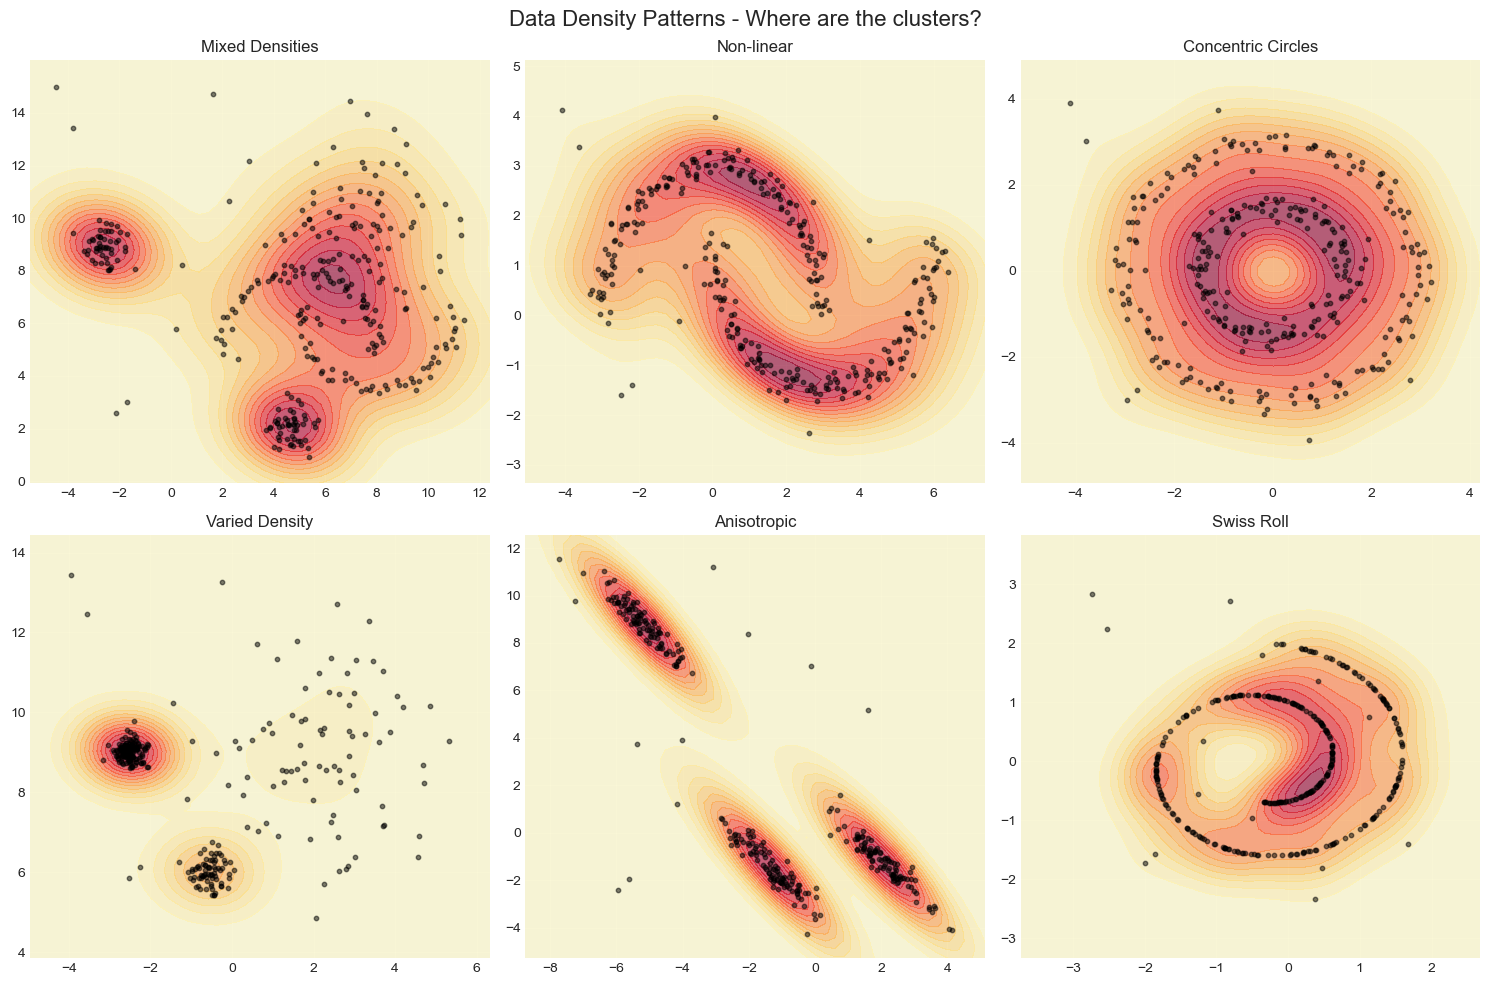


Discovery Questions:
1. Which patterns have clear density-based clusters?
2. How would you define cluster boundaries based on density?
3. Where might K-means fail but density-based clustering succeed?


In [45]:
# Visualize different data densities
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

data_types = ['mixed', 'moons', 'circles', 'varied_density', 'anisotropic', 'swiss_roll']
titles = ['Mixed Densities', 'Non-linear', 'Concentric Circles', 
          'Varied Density', 'Anisotropic', 'Swiss Roll']

for idx, (dtype, title) in enumerate(zip(data_types, titles)):
    X = generate_dbscan_data(dtype, n_samples=300, noise_ratio=0.05)
    
    # Create density plot
    xx, yy, density = create_density_grid(X, resolution=50)
    
    contour = axes[idx].contourf(xx, yy, density, levels=15, cmap='YlOrRd', alpha=0.6)
    axes[idx].scatter(X[:, 0], X[:, 1], c='black', s=10, alpha=0.5)
    axes[idx].set_title(title)
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Data Density Patterns - Where are the clusters?', fontsize=16)
plt.tight_layout()
plt.show()

print("\nDiscovery Questions:")
print("1. Which patterns have clear density-based clusters?")
print("2. How would you define cluster boundaries based on density?")
print("3. Where might K-means fail but density-based clustering succeed?")

### Interactive Density Exploration

Explore how density varies across different datasets!

In [46]:
@widgets.interact(
    data_type=['mixed', 'moons', 'circles', 'varied_density'],
    n_samples=widgets.IntSlider(min=100, max=500, value=300, step=50),
    noise_ratio=widgets.FloatSlider(min=0, max=0.3, value=0.05, step=0.05)
)
def explore_density(data_type, n_samples, noise_ratio):
    X = generate_dbscan_data(data_type, n_samples=n_samples, noise_ratio=noise_ratio)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Raw data
    ax1.scatter(X[:, 0], X[:, 1], c='blue', s=30, alpha=0.6)
    ax1.set_title(f'{data_type} data with {int(noise_ratio*100)}% noise')
    ax1.grid(True, alpha=0.3)
    
    # Density map
    plot_density_map(X, ax=ax2)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Total points: {len(X)}")
    print(f"Noise points added: {int(n_samples * noise_ratio)}")

interactive(children=(Dropdown(description='data_type', options=('mixed', 'moons', 'circles', 'varied_density'…

# Section 2: Understanding DBSCAN Algorithm

## Key Concepts

DBSCAN classifies points into three categories:
1. **Core Points**: Have at least `min_samples` points within `eps` radius
2. **Border Points**: Within `eps` of a core point but not core themselves
3. **Noise Points**: Neither core nor border

Let's visualize these concepts!

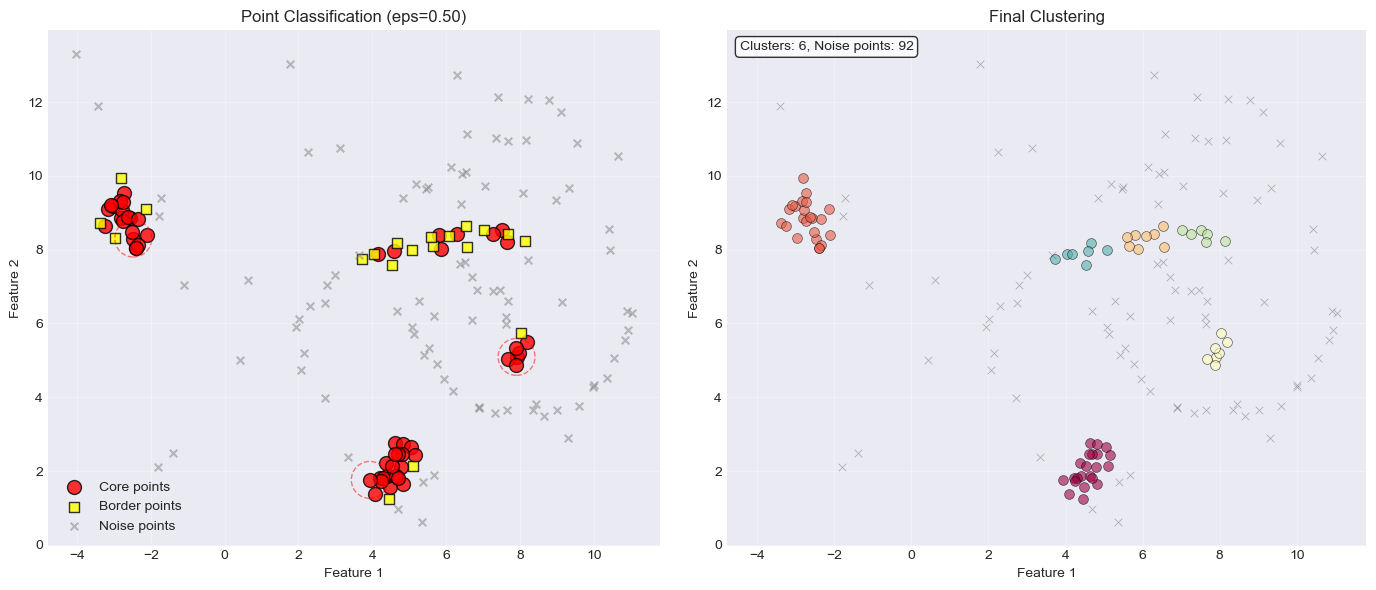


Point Classification:
Core points: 53 (32.1%)
Border points: 20 (12.1%)
Noise points: 92 (55.8%)


In [47]:
# Generate sample data
X_demo = generate_dbscan_data('mixed', n_samples=150, noise_ratio=0.1)

# Set parameters
eps = 0.5
min_samples = 5

# Run our DBSCAN implementation
labels, history, point_types = dbscan_from_scratch(X_demo, eps, min_samples, visualize_steps=True)

# Visualize point types
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Point classification
plot_point_types(X_demo, point_types, eps, ax1)

# Final clustering
plot_dbscan_clusters(X_demo, labels, 'Final Clustering', ax2)

plt.tight_layout()
plt.show()

# Statistics
n_core = np.sum(point_types == 1)
n_border = np.sum(point_types == 2)
n_noise = np.sum(point_types == -1)

print(f"\nPoint Classification:")
print(f"Core points: {n_core} ({100*n_core/len(X_demo):.1f}%)")
print(f"Border points: {n_border} ({100*n_border/len(X_demo):.1f}%)")
print(f"Noise points: {n_noise} ({100*n_noise/len(X_demo):.1f}%)")

### Interactive Point Inspection

Click through different points to understand how DBSCAN classifies them!

In [48]:
print("Explore how individual points are classified:")
print("- Adjust eps and min_samples")
print("- Select different points to inspect their neighborhoods")
print("")

interactive_point_inspection()

Explore how individual points are classified:
- Adjust eps and min_samples
- Select different points to inspect their neighborhoods



interactive(children=(FloatSlider(value=0.5, description='eps', max=3.0, min=0.1), IntSlider(value=4, descript…

# Section 4: Parameter Tuning (eps and min_samples)

## The Art of Choosing Parameters

DBSCAN's performance heavily depends on two parameters:
- **eps**: The radius of neighborhood
- **min_samples**: Minimum points to form a dense region

Let's learn how to choose them!

### Parameter Space Exploration

Let's systematically explore the parameter space!

### Interactive Parameter Tuning

Experiment with parameters in real-time!

In [49]:
print("Adjust the parameters and see how clustering changes:")
print("- eps: Controls the neighborhood size")
print("- min_samples: Minimum density requirement")
print("")

interactive_dbscan_parameters()

Adjust the parameters and see how clustering changes:
- eps: Controls the neighborhood size
- min_samples: Minimum density requirement



interactive(children=(Dropdown(description='data_type', options=('mixed', 'moons', 'circles', 'varied_density'…

# Section 5: DBSCAN vs K-Means Comparison

## Head-to-Head Comparison

Let's see where DBSCAN shines and where K-means might be better!

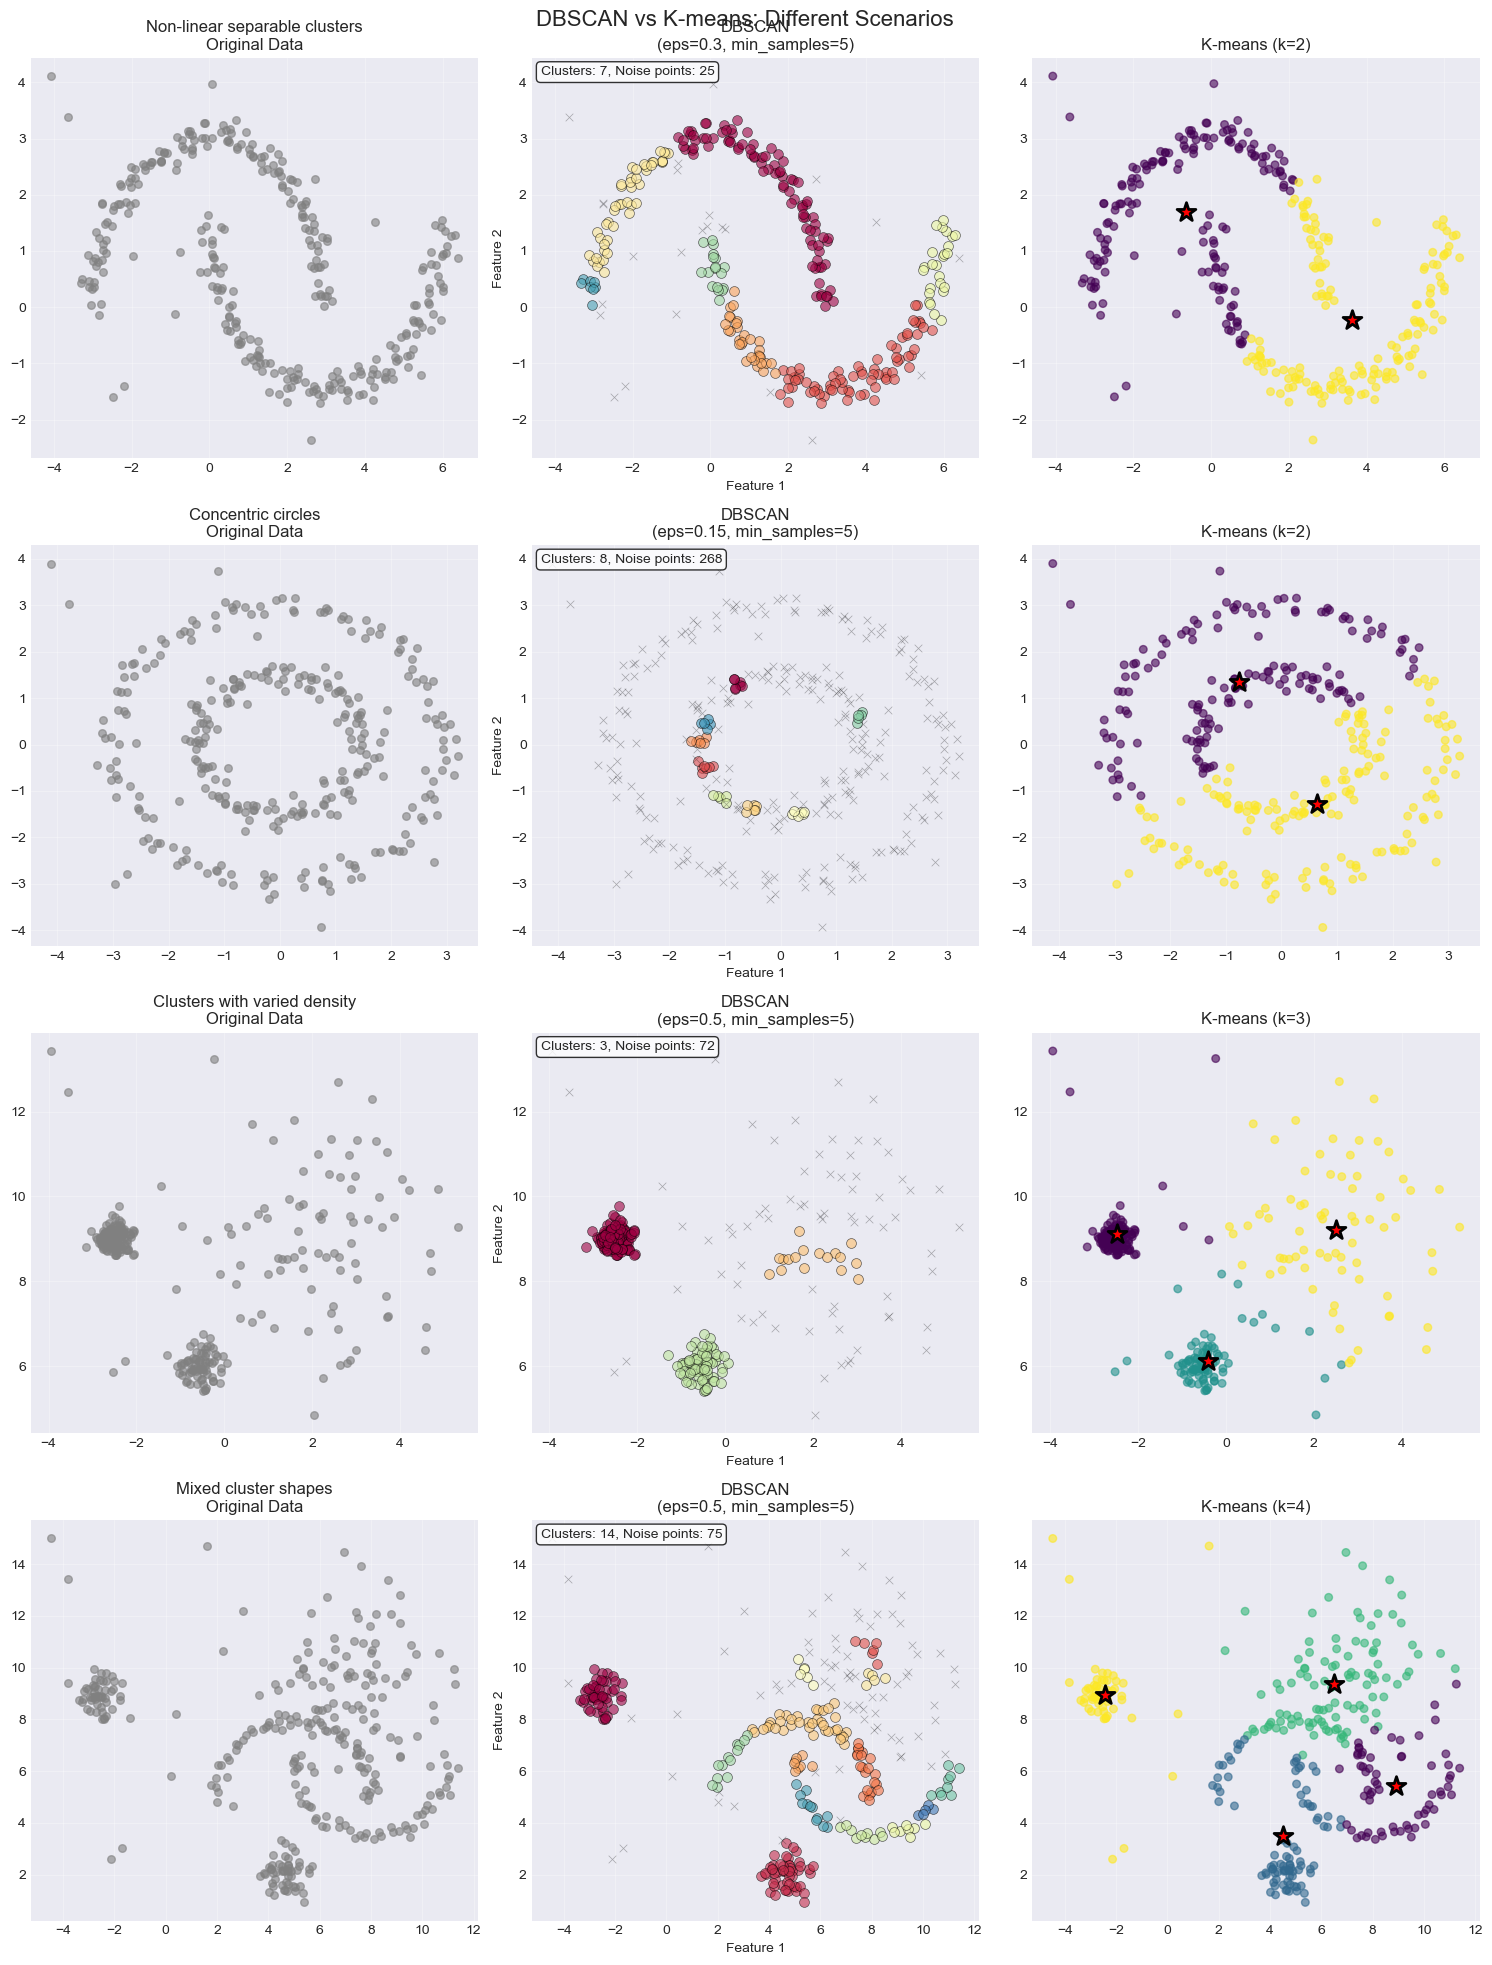


Key Observations:
1. DBSCAN handles non-spherical clusters better
2. DBSCAN can identify and ignore noise
3. K-means forces all points into clusters
4. DBSCAN doesn't need to know the number of clusters beforehand


In [50]:
# Test different scenarios
scenarios = [
    ('moons', 0.3, 5, 2, 'Non-linear separable clusters'),
    ('circles', 0.15, 5, 2, 'Concentric circles'),
    ('varied_density', 0.5, 5, 3, 'Clusters with varied density'),
    ('mixed', 0.5, 5, 4, 'Mixed cluster shapes')
]

fig, axes = plt.subplots(len(scenarios), 3, figsize=(15, 5*len(scenarios)))

for idx, (data_type, eps, min_samples, k, description) in enumerate(scenarios):
    X = generate_dbscan_data(data_type, n_samples=300, noise_ratio=0.05)
    
    # Original data
    axes[idx, 0].scatter(X[:, 0], X[:, 1], c='gray', s=30, alpha=0.6)
    axes[idx, 0].set_title(f'{description}\nOriginal Data')
    axes[idx, 0].grid(True, alpha=0.3)
    
    # DBSCAN
    dbscan_labels = DBSCAN(eps=eps, min_samples=min_samples).fit_predict(X)
    plot_dbscan_clusters(X, dbscan_labels, f'DBSCAN\n(eps={eps}, min_samples={min_samples})', axes[idx, 1])
    
    # K-means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(X)
    scatter = axes[idx, 2].scatter(X[:, 0], X[:, 1], c=kmeans_labels, s=30, alpha=0.6, cmap='viridis')
    axes[idx, 2].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
                        c='red', s=200, marker='*', edgecolors='black', linewidth=2)
    axes[idx, 2].set_title(f'K-means (k={k})')
    axes[idx, 2].grid(True, alpha=0.3)

plt.suptitle('DBSCAN vs K-means: Different Scenarios', fontsize=16)
plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("1. DBSCAN handles non-spherical clusters better")
print("2. DBSCAN can identify and ignore noise")
print("3. K-means forces all points into clusters")
print("4. DBSCAN doesn't need to know the number of clusters beforehand")

### Detailed Comparison

Let's compare the algorithms on a challenging dataset!


Comparison Results:
DBSCAN: 2 clusters, 40 noise points
K-means: 3 clusters (predefined), 0 noise points

DBSCAN Silhouette: 0.578
K-means Silhouette: 0.470


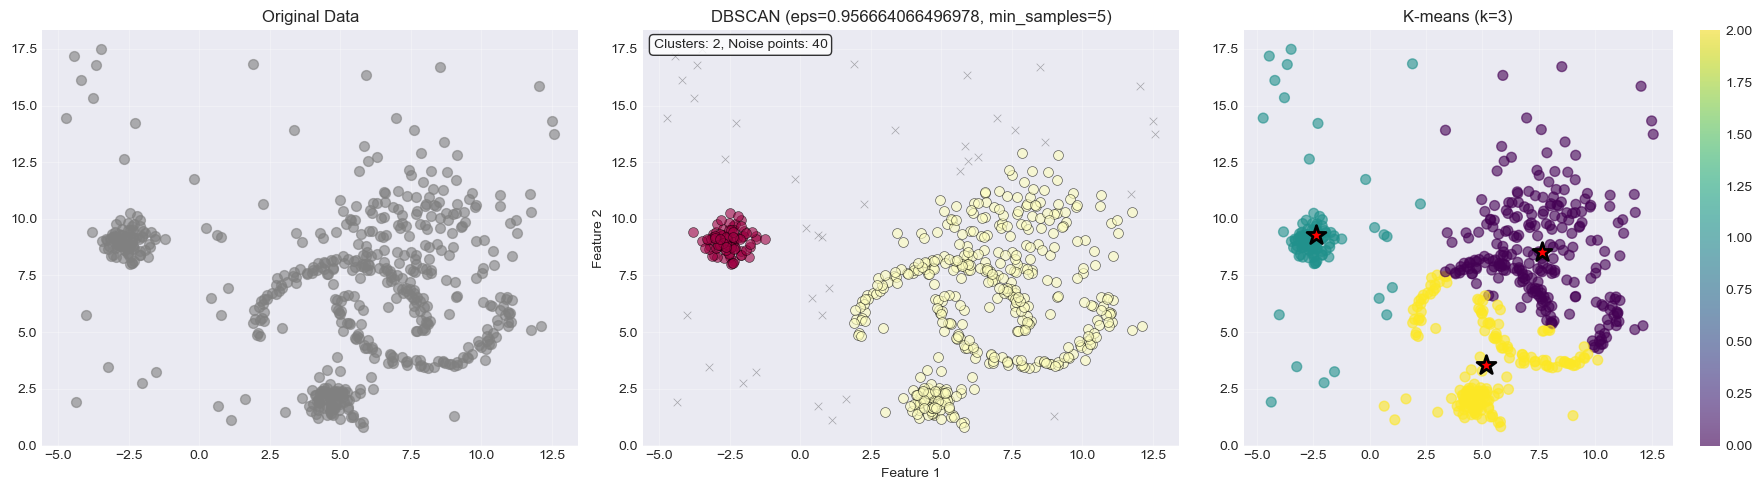


When to use each algorithm:

Use DBSCAN when:
- Clusters have arbitrary shapes
- There's noise in the data
- You don't know the number of clusters
- Clusters have different densities (with careful parameter tuning)

Use K-means when:
- Clusters are roughly spherical
- You know the number of clusters
- Speed is critical (K-means is generally faster)
- All points should be assigned to clusters


In [51]:
# Create a challenging dataset
X_challenge = generate_dbscan_data('mixed', n_samples=500, noise_ratio=0.1)

# Find optimal parameters
optimal_eps = estimate_eps(X_challenge, k=4, percentile=90)

# Compare
fig = compare_dbscan_kmeans(X_challenge, eps=optimal_eps, min_samples=5, k=3)
plt.show()

print("\nWhen to use each algorithm:")
print("\nUse DBSCAN when:")
print("- Clusters have arbitrary shapes")
print("- There's noise in the data")
print("- You don't know the number of clusters")
print("- Clusters have different densities (with careful parameter tuning)")
print("\nUse K-means when:")
print("- Clusters are roughly spherical")
print("- You know the number of clusters")
print("- Speed is critical (K-means is generally faster)")
print("- All points should be assigned to clusters")

### Algorithm Stability Comparison

How stable are the algorithms with different initializations?

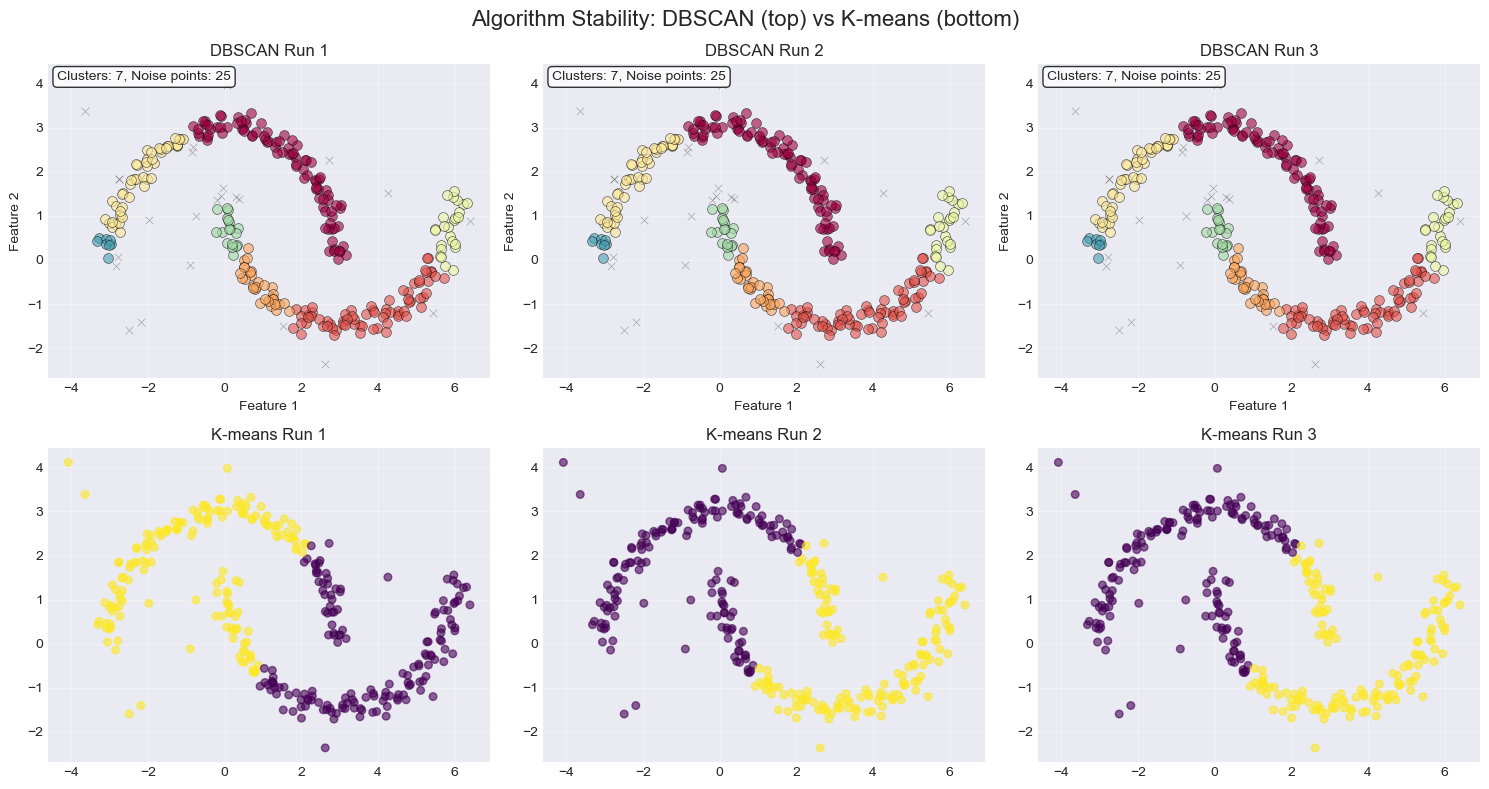


Stability Analysis:
- DBSCAN is deterministic: same parameters = same results
- K-means can vary with different random initializations
- K-means++ initialization improves K-means stability


In [52]:
# Test stability
X_stability = generate_dbscan_data('moons', n_samples=300, noise_ratio=0.05)

# Run multiple times
n_runs = 6
fig, axes = plt.subplots(2, n_runs//2, figsize=(15, 8))
axes = axes.flatten()

for i in range(n_runs):
    if i < n_runs//2:
        # DBSCAN (deterministic)
        labels = DBSCAN(eps=0.3, min_samples=5).fit_predict(X_stability)
        plot_dbscan_clusters(X_stability, labels, f'DBSCAN Run {i+1}', axes[i])
    else:
        # K-means (random initialization)
        kmeans = KMeans(n_clusters=2, init='random', n_init=1, random_state=i)
        labels = kmeans.fit_predict(X_stability)
        axes[i].scatter(X_stability[:, 0], X_stability[:, 1], c=labels, s=30, alpha=0.6, cmap='viridis')
        axes[i].set_title(f'K-means Run {i-n_runs//2+1}')
        axes[i].grid(True, alpha=0.3)

plt.suptitle('Algorithm Stability: DBSCAN (top) vs K-means (bottom)', fontsize=16)
plt.tight_layout()
plt.show()

print("\nStability Analysis:")
print("- DBSCAN is deterministic: same parameters = same results")
print("- K-means can vary with different random initializations")
print("- K-means++ initialization improves K-means stability")

# Section 6: Real-World Applications

## Application 1: Anomaly Detection

DBSCAN naturally identifies outliers as noise points!


Anomaly Detection Performance:
True Positives: 18
False Positives: 24
True Negatives: 276
False Negatives: 2

Precision: 0.429
Recall: 0.900
F1-Score: 0.581


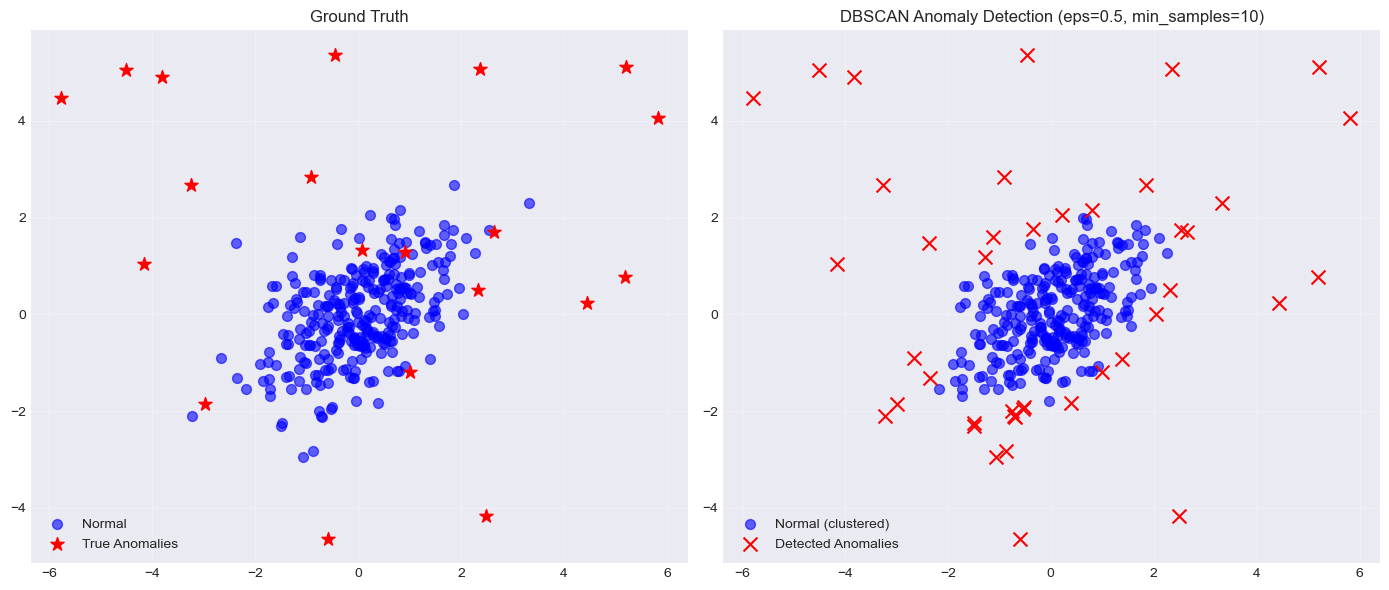


How DBSCAN detects anomalies:
1. Normal data forms dense clusters
2. Anomalies are isolated points in sparse regions
3. DBSCAN classifies sparse points as noise (anomalies)
4. No need to train separate anomaly detection model!


In [53]:
# Anomaly detection demonstration
fig = anomaly_detection_demo()
plt.show()

print("\nHow DBSCAN detects anomalies:")
print("1. Normal data forms dense clusters")
print("2. Anomalies are isolated points in sparse regions")
print("3. DBSCAN classifies sparse points as noise (anomalies)")
print("4. No need to train separate anomaly detection model!")

## Application 2: Geographic/Spatial Clustering

Perfect for identifying regions of interest in spatial data!


Geographic Clustering Results:
Districts identified: 2
Rural/Isolated locations: 62

District 1:
  - Locations: 271
  - Center: (40.7100, -74.0043)

District 2:
  - Locations: 7
  - Center: (40.6182, -74.0316)


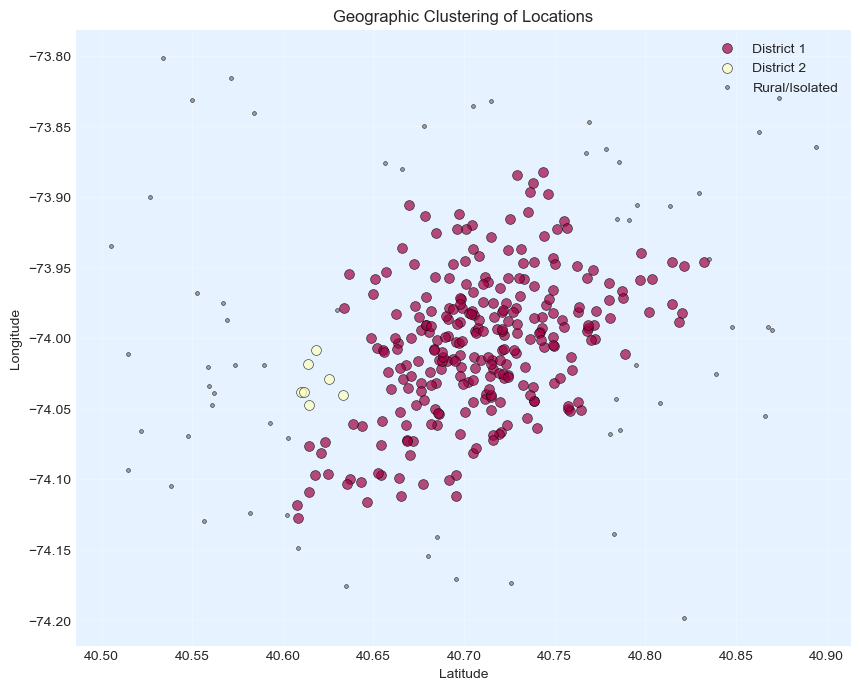


Advantages for geographic data:
- Identifies areas of arbitrary shape
- Naturally handles different density urban/suburban/rural areas
- eps parameter can represent physical distance
- Useful for urban planning, delivery zones, market analysis


In [54]:
# Geographic clustering demonstration
fig = geographic_clustering_demo()
plt.show()

print("\nAdvantages for geographic data:")
print("- Identifies areas of arbitrary shape")
print("- Naturally handles different density urban/suburban/rural areas")
print("- eps parameter can represent physical distance")
print("- Useful for urban planning, delivery zones, market analysis")

## Application 3: Network Traffic Analysis

Identify patterns and anomalies in network behavior!

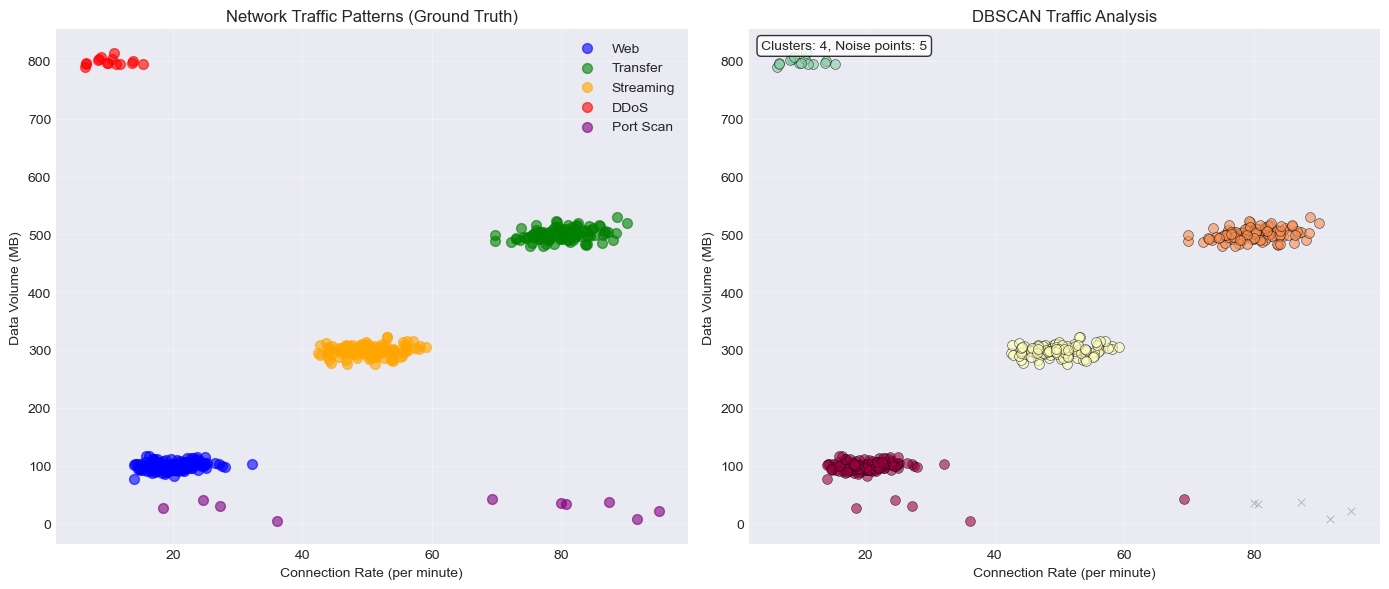


Network Traffic Analysis Results:
Normal traffic patterns identified: 4 clusters
Suspicious connections detected: 5
Actual attacks in dataset: 25
Attacks correctly identified: 5
Detection rate: 20.0%


In [55]:
# Simulate network traffic data
np.random.seed(42)

# Normal traffic patterns (different types)
web_browsing = np.random.multivariate_normal([20, 100], [[10, 5], [5, 50]], 150)
file_transfer = np.random.multivariate_normal([80, 500], [[20, 10], [10, 100]], 100)
streaming = np.random.multivariate_normal([50, 300], [[15, 8], [8, 80]], 120)

# Attack patterns (anomalies)
ddos = np.random.multivariate_normal([10, 800], [[5, 2], [2, 30]], 15)
port_scan = np.random.uniform([0, 0], [100, 50], (10, 2))

# Combine all traffic
X_traffic = np.vstack([web_browsing, file_transfer, streaming, ddos, port_scan])
traffic_labels = np.array([0]*150 + [1]*100 + [2]*120 + [3]*15 + [4]*10)

# Apply DBSCAN
dbscan = DBSCAN(eps=50, min_samples=10)
detected_labels = dbscan.fit_predict(X_traffic)

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# True traffic types
traffic_names = ['Web', 'Transfer', 'Streaming', 'DDoS', 'Port Scan']
colors = ['blue', 'green', 'orange', 'red', 'purple']

for i, (name, color) in enumerate(zip(traffic_names, colors)):
    mask = traffic_labels == i
    ax1.scatter(X_traffic[mask, 0], X_traffic[mask, 1], 
               c=color, s=50, alpha=0.6, label=name)

ax1.set_xlabel('Connection Rate (per minute)')
ax1.set_ylabel('Data Volume (MB)')
ax1.set_title('Network Traffic Patterns (Ground Truth)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# DBSCAN detection
plot_dbscan_clusters(X_traffic, detected_labels, 
                    'DBSCAN Traffic Analysis', ax2)
ax2.set_xlabel('Connection Rate (per minute)')
ax2.set_ylabel('Data Volume (MB)')

plt.tight_layout()
plt.show()

# Analysis
anomaly_indices = np.where(detected_labels == -1)[0]
actual_attacks = np.where(traffic_labels >= 3)[0]
detected_attacks = np.intersect1d(anomaly_indices, actual_attacks)

print("\nNetwork Traffic Analysis Results:")
print("="*50)
print(f"Normal traffic patterns identified: {len(set(detected_labels)) - 1} clusters")
print(f"Suspicious connections detected: {len(anomaly_indices)}")
print(f"Actual attacks in dataset: {len(actual_attacks)}")
print(f"Attacks correctly identified: {len(detected_attacks)}")
print(f"Detection rate: {100*len(detected_attacks)/len(actual_attacks):.1f}%")

# Summary & Next Steps

## What We've Learned

### DBSCAN Key Concepts:
1. **Density-based**: Finds clusters of arbitrary shape
2. **No K required**: Discovers the number of clusters
3. **Noise handling**: Naturally identifies outliers
4. **Parameters**: eps (radius) and min_samples (density threshold)
5. **Deterministic**: Same parameters always give same results

### When to Use DBSCAN:
- Non-spherical clusters
- Unknown number of clusters
- Presence of noise/outliers
- Varying cluster densities (with careful tuning)
- Spatial/geographic data

### When NOT to Use DBSCAN:
- Very high-dimensional data (curse of dimensionality)
- Clusters with vastly different densities
- When all points must be clustered
- Large datasets (consider HDBSCAN for better performance)

## Practical Guidelines

### Parameter Selection:
1. **min_samples**: Start with 2 * dimensions, minimum 3
2. **eps**: Use k-distance plot, look for elbow
3. Consider domain knowledge (e.g., physical distance for geographic data)

### Preprocessing:
1. **Always** scale/normalize features
2. Consider dimensionality reduction for high-D data
3. Remove or impute missing values

## Advanced Topics to Explore

1. **HDBSCAN**: Hierarchical DBSCAN, better for varying densities
2. **OPTICS**: Ordering points to identify clustering structure
3. **ST-DBSCAN**: Spatial-Temporal DBSCAN for time-series
4. **GPU Acceleration**: For large-scale datasets

## Practice Exercises

1. **Easy**: Apply DBSCAN to the Iris dataset. Compare with K-means results.

2. **Medium**: Implement a function that automatically selects optimal eps using the elbow method on k-distance graph.

3. **Hard**: Create a dataset where DBSCAN fails. Then preprocess it to make DBSCAN work.

4. **Project**: Use DBSCAN for customer segmentation on a real dataset. Compare with K-means and hierarchical clustering.

## Further Reading

- Original DBSCAN paper: Ester et al. (1996)
- HDBSCAN: Campello et al. (2013)
- OPTICS: Ankerst et al. (1999)
- Comparison of clustering algorithms: Scikit-learn documentation

## Final Challenge: Multi-Density Clustering

Can you find parameters that work for this challenging dataset?

In [56]:
# Create a challenging multi-density dataset
np.random.seed(42)

# Dense cluster
dense = np.random.multivariate_normal([0, 0], [[0.1, 0], [0, 0.1]], 200)

# Medium density cluster
medium = np.random.multivariate_normal([3, 3], [[0.3, 0], [0, 0.3]], 150)

# Sparse cluster
sparse = np.random.multivariate_normal([6, 0], [[1, 0], [0, 1]], 100)

# Noise
noise = np.random.uniform([-2, -2], [8, 5], (30, 2))

X_challenge = np.vstack([dense, medium, sparse, noise])

print("Challenge: Find DBSCAN parameters that correctly identify all three clusters!")
print("Hint: You might need to experiment with different approaches...")
print("")

# Interactive widget for the challenge
@widgets.interact(
    eps=widgets.FloatSlider(min=0.05, max=2.0, value=0.5, step=0.05),
    min_samples=widgets.IntSlider(min=3, max=20, value=5)
)
def challenge_clustering(eps, min_samples):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X_challenge)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Ground truth
    true_labels = np.array([0]*200 + [1]*150 + [2]*100 + [-1]*30)
    for i in range(-1, 3):
        mask = true_labels == i
        if i == -1:
            ax1.scatter(X_challenge[mask, 0], X_challenge[mask, 1], 
                       c='black', s=30, marker='x', alpha=0.5, label='Noise')
        else:
            ax1.scatter(X_challenge[mask, 0], X_challenge[mask, 1], 
                       s=50, alpha=0.6, label=f'Cluster {i+1}')
    ax1.set_title('Ground Truth: 3 clusters + noise')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # DBSCAN result
    plot_dbscan_clusters(X_challenge, labels, 
                        f'Your Result (eps={eps:.2f}, min_samples={min_samples})', ax2)
    
    plt.tight_layout()
    plt.show()
    
    # Check success
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    if n_clusters == 3:
        print("Great! You found 3 clusters!")
        # Check cluster quality
        mask = labels != -1
        if np.sum(mask) > 0:
            ari = adjusted_rand_score(true_labels[mask], labels[mask])
            print(f"Clustering quality (ARI): {ari:.3f}")
            if ari > 0.8:
                print("Excellent! You've successfully solved the challenge!")
            elif ari > 0.5:
                print("Good, but can you do better?")
            else:
                print("The clusters don't match well. Try different parameters.")
    else:
        print(f"Found {n_clusters} clusters. Target is 3. Keep trying!")

print("\n" + "="*50)
print("Congratulations on completing the DBSCAN discovery journey!")
print("You now have a deep understanding of density-based clustering.")
print("Keep experimenting and applying these concepts to real problems!")

Challenge: Find DBSCAN parameters that correctly identify all three clusters!
Hint: You might need to experiment with different approaches...



interactive(children=(FloatSlider(value=0.5, description='eps', max=2.0, min=0.05, step=0.05), IntSlider(value…


Congratulations on completing the DBSCAN discovery journey!
You now have a deep understanding of density-based clustering.
Keep experimenting and applying these concepts to real problems!
